In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import random
import wandb
import torch.utils
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import os
import csv
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
import scipy
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class AudioClassificationDataset(Dataset):
    def __init__(self, data_dir, metadata_file, transform=None, batch_size=10):
        self.data_dir = data_dir
        self.metadata = self.extract_metadata(metadata_file)
        self.transform = transform
        self.batch_size = batch_size
        self.label_encoder = self.encode_labels(self.metadata['label'])
        
    # Itt tortenik a labelek es a hozzajuk tartozo fileok kiszedese a csv segitsegevel
    def extract_metadata(self, metadata_file):
        metadata_df = pd.read_csv(metadata_file)
        metadata_df['Filename'] = metadata_df['Filename'].apply(lambda x: x.split("/")[-1])
        metadata = metadata_df[['Label', 'Filename']]      
        metadata.columns = ['label', 'filename']
        return metadata

    def encode_labels(self,labels):
        unique_labels = labels.unique()
        encoded_dict = {label: num for label, num in zip(unique_labels, range(len(unique_labels)))}
        return encoded_dict
    
    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        label = self.metadata['label'][idx]
        filename = self.metadata['filename'][idx]
        audio_file = os.path.join(self.data_dir, label, filename)
        waveform, sample_rate = librosa.load(audio_file, sr=None) 
        mel_spectrogram = librosa.feature.melspectrogram(y=waveform, sr=sample_rate, fmin=800, fmax=12000)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        #mel_spectrogram_db = normalize_decibel_spectrogram(mel_spectrogram_db)
        if mel_spectrogram_db.shape != 626:
                mel_spectrogram_db = resize_mel_spectrogram(mel_spectrogram_db, 626) 
        mel_spec_db_tensor = torch.from_numpy(mel_spectrogram_db).unsqueeze(0)
        mel_spec_db_tensor = normalize_mel_spectrogram(mel_spec_db_tensor)
        class_label = self.label_encoder[label]
        class_label_tensor = torch.tensor(class_label).unsqueeze(0)
        return mel_spec_db_tensor, class_label_tensor

In [20]:
class AudioClassifier(pl.LightningModule):
    def __init__(self, num_classes, droupout_rate = 0.5, learning_rate = 0.001, weight_decay = 0.01, optimizer= 'adamw'):
        super(AudioClassifier, self).__init__()  

        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.fc1 = nn.Linear(256 * 16 * 78, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(droupout_rate)
        
        self.lr = learning_rate
        self.w_dec = weight_decay
        self.optimizer = optimizer
        
        self.y_true = []
        self.y_pred = []

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        num_features = x.size(1) * x.size(2) * x.size(3)
        x = x.view(-1, num_features)  # Reshape based on the calculated number of features
        x = self.fc1(x)
        x = self.fc2(x)
        return x

    def test_step(self, batch, batch_idx):
        x, y = batch
        y = y.squeeze()
        y_pred = self(x)
        test_loss = F.cross_entropy(y_pred, y)
        y_pred = torch.argmax(self(x), dim=1)
        test_acc = torch.sum(y_pred == y).item() / y.size(0)
        self.y_true.extend(y.cpu().numpy())
        self.y_pred.extend(y_pred.cpu().numpy())
        self.log('test_loss', test_loss.item(), on_epoch=True)
        self.log('test_acc', test_acc, on_epoch=True)
     
    
    def on_test_epoch_end(self):
        conf_matrix = confusion_matrix(self.y_true, self.y_pred)
        return conf_matrix,self.y_true,self.y_pred

In [4]:
def resize_mel_spectrogram(mel_spec, target_shape):
    zoom_factors = (1, target_shape / mel_spec.shape[1])
    return scipy.ndimage.zoom(mel_spec, zoom_factors)

def normalize_mel_spectrogram(mel_spec_tensor):
    # Find the min and max values
    min_value = mel_spec_tensor.min()
    max_value = mel_spec_tensor.max()
    # Normalize the mel spectrogram tensor
    normalized_mel_spec = (mel_spec_tensor - min_value) / (max_value - min_value)
    return normalized_mel_spec

In [5]:
data_dir = '/kaggle/input/birdclef-2023/train_audio'
metadata_file = '/kaggle/input/filtered-metadata/filtered_metadata.csv'
dataset = AudioClassificationDataset(data_dir, metadata_file)
melspec, label = dataset[6000]
print(melspec)

tensor([[[0.0009, 0.1890, 0.3223,  ..., 0.2930, 0.2125, 0.0009],
         [0.0009, 0.1927, 0.3607,  ..., 0.3211, 0.3067, 0.0009],
         [0.0009, 0.1681, 0.3977,  ..., 0.2361, 0.3089, 0.0009],
         ...,
         [0.0009, 0.0681, 0.2798,  ..., 0.2214, 0.2110, 0.0009],
         [0.0009, 0.0715, 0.2865,  ..., 0.2042, 0.1879, 0.0009],
         [0.0009, 0.0554, 0.2665,  ..., 0.2416, 0.1919, 0.0009]]])


In [6]:
with open('/kaggle/input/birdclef-test-indicies/test_indices.pkl', 'rb') as f:
    test_indices = pickle.load(f)
test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=64, sampler=test_sampler,num_workers=3)

In [7]:
run = wandb.init()
model_name = 'model-vqm3w2nz:v3'
artifact = run.use_artifact('deepbirding/deepbirding/' + model_name, type='model')
artifact_dir = artifact.download()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Downloading large artifact model-vqm3w2nz:v3, 625.93MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:3.8


In [21]:
checkpoint = torch.load('/kaggle/working/artifacts/model-vqm3w2nz:v3/model.ckpt')
eval_model = AudioClassifier(num_classes=264)
eval_model.load_state_dict(checkpoint['state_dict'])
eval_model.eval()
trainer = pl.Trainer(accelerator="gpu",devices=1, precision="16-mixed")

In [24]:
trainer.test(eval_model, dataloaders=test_loader)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.44623202085494995    │
│         test_loss         │     2.623845338821411     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.623845338821411, 'test_acc': 0.44623202085494995}]

In [ ]:
conf_matrix, y_true, y_pred = eval_model.on_test_epoch_end()
print("Confusion Matrix:")
print(len(y_pred))

conf_matrix = confusion_matrix(y_true, y_pred)

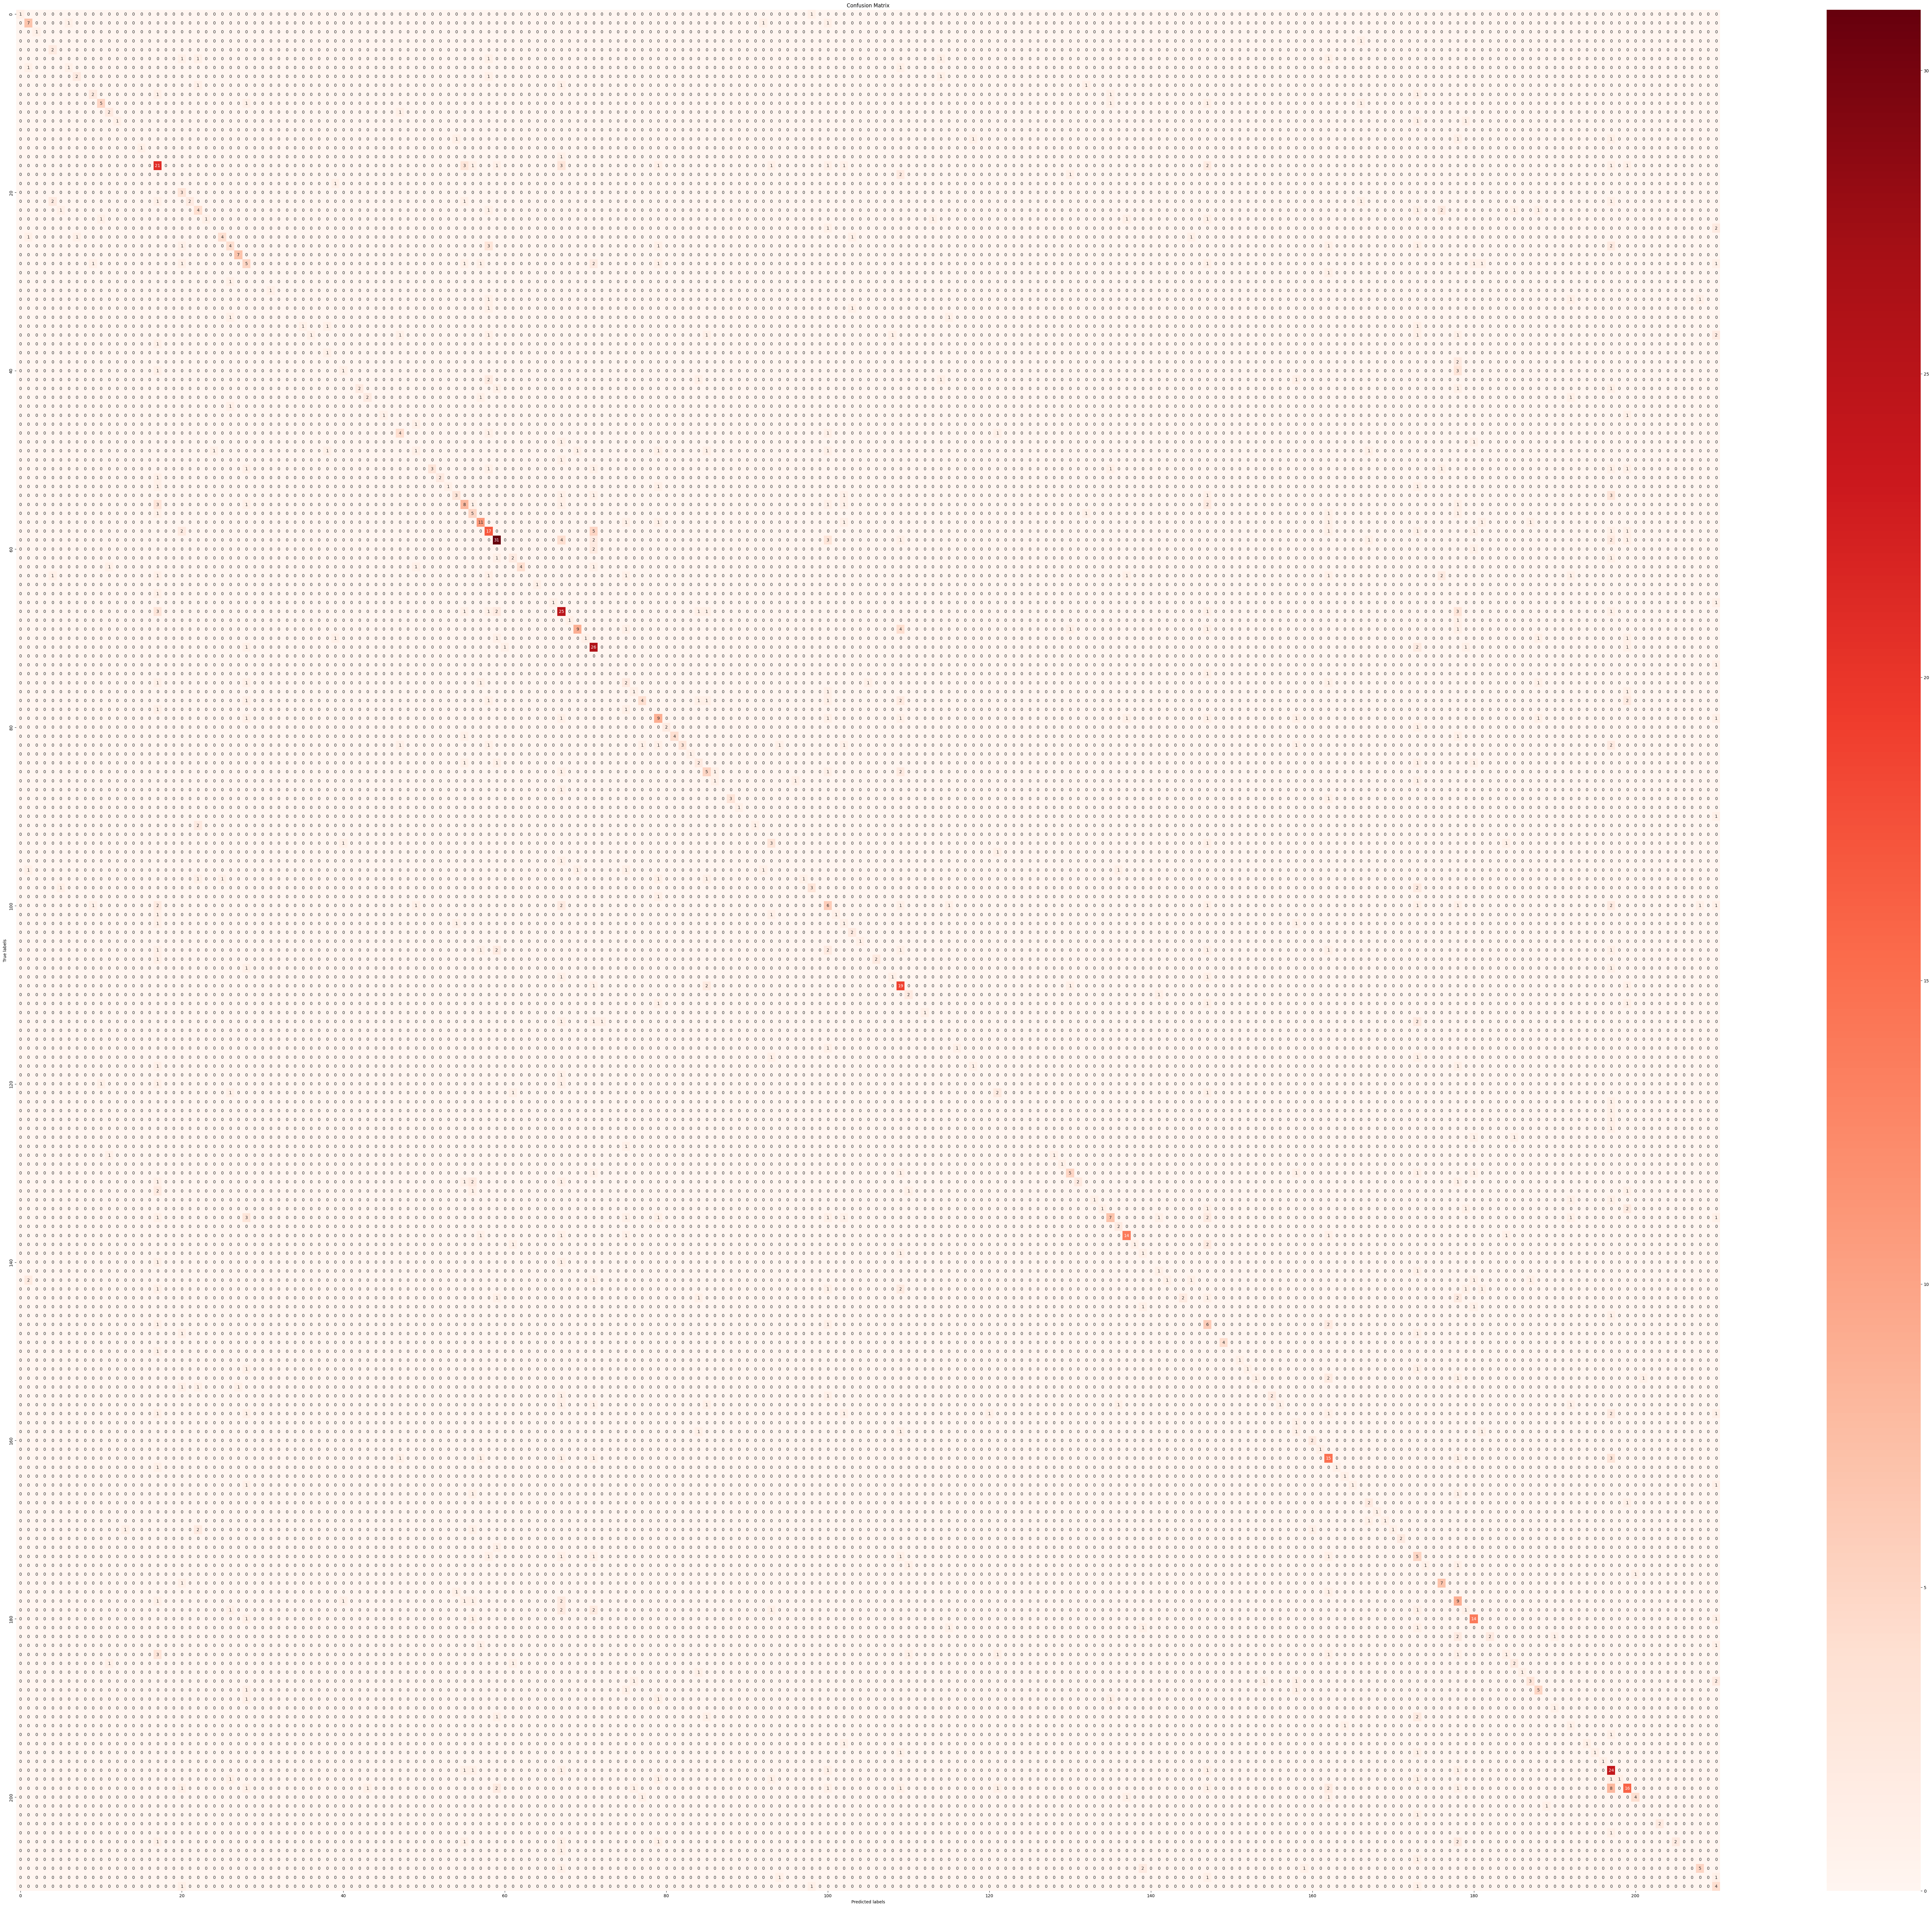

In [36]:
# Plot the confusion matrix
plt.figure(figsize=(90, 80))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=20, yticklabels=20)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig(f'conf_matrix_{model_name}.png')
plt.show()